In [2]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

In [3]:
def create_signal_of_diracs(length=16000, num_diracs=20):
    signal = torch.zeros(length)
    for _ in range(num_diracs):
        idx = np.random.randint(0, length)
        amplitude = np.random.uniform(0, 1)
        signal[idx] = amplitude
    return signal

In [4]:
signal = create_signal_of_diracs(length=3968, num_diracs=560)

# Part 1 : Windowed sinc filter

In [5]:
def get_window_length(fs=16000, center_frequency=1000):
    filter_transition_band = center_frequency / 5 # a good approximation.
    filter_order = fs / filter_transition_band # a good approximation.
    window_length = (filter_order // 2)*2  + 1
    return window_length

In [6]:
def hann_window(window_length):
    n = torch.arange(window_length)
    return 0.5 * (1 - torch.cos(2 * np.pi * n / window_length))

In [7]:
def LP_filter(fs, freq_cutoff):
    '''
    windowed sinc filter
    '''
    window_length = get_window_length(fs, center_frequency=freq_cutoff/2)
    print("window_length :", window_length)
    
    # Get hann
    hanning = hann_window(window_length)
    print(hanning.shape)

    # Get sinc
    n = torch.arange(window_length)
    nyquist_f = fs / 2
    f_c_normalized = freq_cutoff / nyquist_f
    sinc = f_c_normalized * torch.special.sinc( (n - window_length//2) * f_c_normalized)
    print(sinc.shape)
    windowed_sinc = sinc * hanning

    
    return windowed_sinc

window_length : 81.0
torch.Size([81])
torch.Size([81])


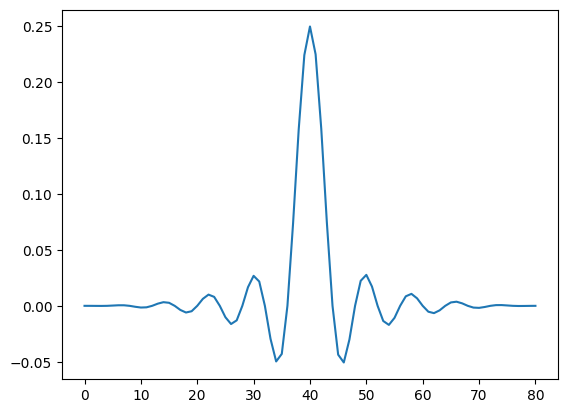

In [10]:
windowed_sinc = LP_filter(fs=16000, freq_cutoff=2000)
plt.plot(windowed_sinc)

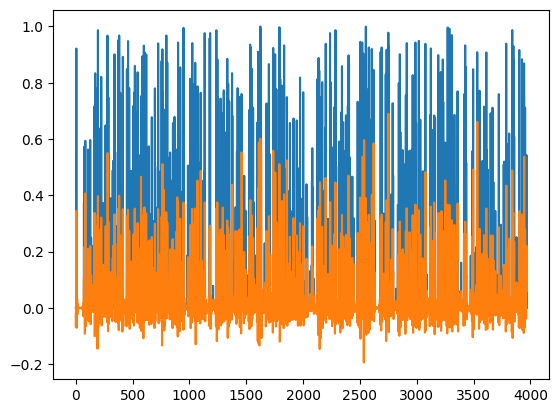

In [156]:
lp_filtered_signal = scipy.signal.convolve(signal, windowed_sinc, mode='same')
plt.plot(signal)
plt.plot(lp_filtered_signal)

In [157]:
f, t, Zxx1 = scipy.signal.stft(lp_filtered_signal, fs=16000, nperseg=256)

# plt.figure(figsize=(10, 6))
# plt.pcolormesh(t, f, np.abs(Zxx1), shading='gouraud')
# plt.title("STFT Magnitude of Diracs - Diracs Hann")
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar(label='Magnitude')
# plt.show()

# Part 2 : Band pass filter

In [158]:
def BP_filter(fs, fc_high, fc_low):
    # window_length = 4 * int(fs / (fc_high- fc_low)) + 1
    window_length = get_window_length(center_frequency=(fc_high + fc_low) / 2)
    # print("window_length :", window_length)
    
    # Generate the indices for the filter coefficients
    n = torch.arange(window_length) - window_length // 2

    # Generate the low pass filter (windowed sinc)
    half_bandwidth = (fc_high - fc_low)/2
    nyquist_fs = fs / 2
    sinc = 2 * half_bandwidth / nyquist_fs * torch.sinc(half_bandwidth * n / nyquist_fs) # we have to multiply by 2 because when translating, we get the energy of all negative frequencies!
    h_lp = sinc * hann_window(window_length)

    # Frequency shift to convert low pass to band pass
    fc_center = (fc_high + fc_low) / 2
    h_bp = h_lp * torch.cos(2 * np.pi * fc_center * n / fs)

    return h_bp
    

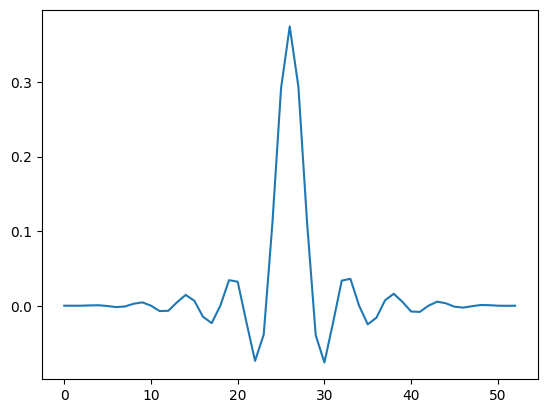

In [159]:
h_bp = BP_filter(16000, 3000,0)
plt.plot(h_bp)

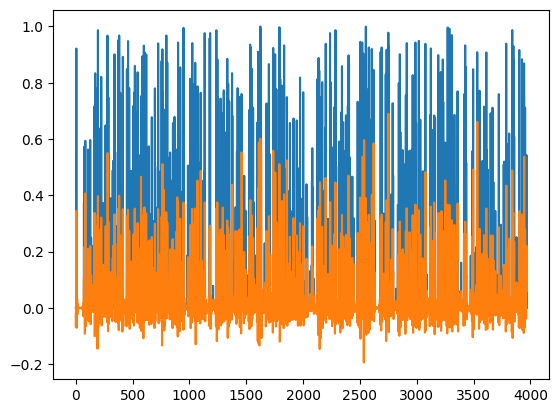

In [160]:
bp_filtered_signal = scipy.signal.convolve(signal, h_bp, mode='same')
plt.plot(signal)
plt.plot(bp_filtered_signal)

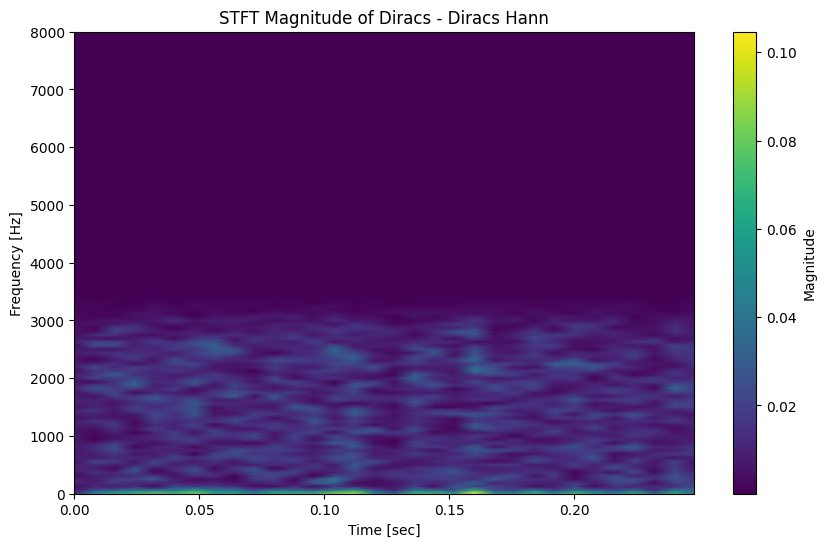

In [161]:
f, t, Zxx2 = scipy.signal.stft(np.array(bp_filtered_signal, dtype=float), sample_rate, nperseg=256)

plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(Zxx2), shading='gouraud')
plt.title("STFT Magnitude of Diracs - Diracs Hann")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude')
plt.show()

(-0.1, 0.1)

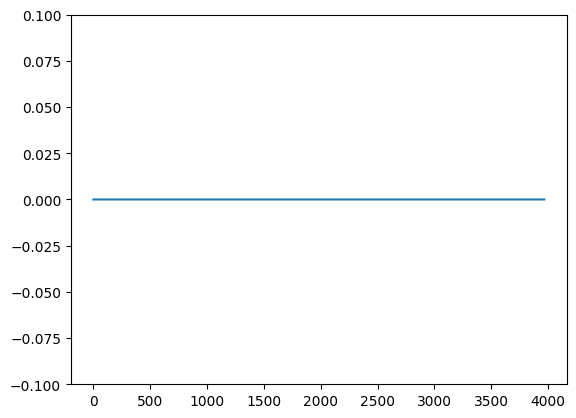

In [164]:
plt.plot(lp_filtered_signal-bp_filtered_signal)
plt.ylim(-0.1, 0.1)

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.pcolormesh(t, f, np.abs(Zxx2)-np.abs(Zxx1), shading='gouraud')
# plt.title("STFT Magnitude of Diracs - Diracs Hann")
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar(label='Magnitude')
# plt.show()